In [58]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from pandas.tseries.offsets import DateOffset
from pandas.plotting import autocorrelation_plot
import pandas.testing as tm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from numpy import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
# C:/Users/marce/AppData/Local/Programs/Python/Python310/python.exe -m pip install sklearn  

In [59]:
# Leitura do CSV e setando como Time
df = pd.read_csv('FT03_18_19.csv',delimiter=';', parse_dates=True)
df['Time'] = pd.to_datetime(df.Time)
df = df[df['Time'].notna()]
df = df.set_index('Time')
df = df.resample("D").last()

In [60]:
# Visualizando o final da serie temporal
df.tail()

,Vazao03
Time,
2019-12-27,105.57
2019-12-28,104.87
2019-12-29,98.95
2019-12-30,103.32
2019-12-31,104.90


<AxesSubplot:xlabel='Time'>

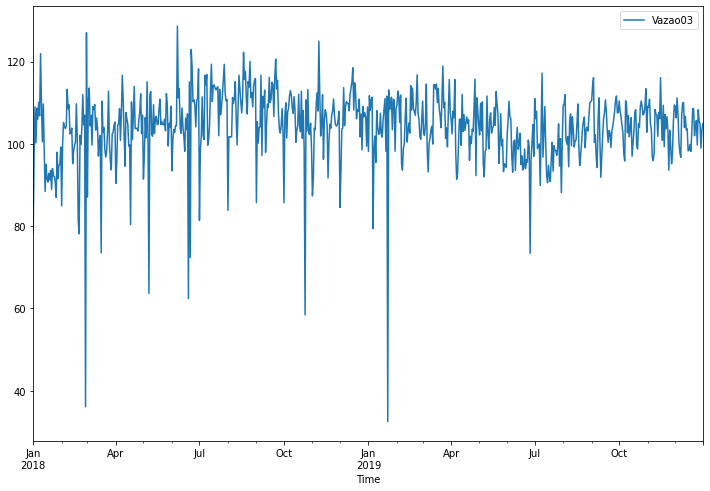

In [61]:
# Setando quem é a coluna e plotando-o completo
df.columns = ['Vazao03']
df.plot(figsize=(12,8))

In [62]:
# Utilizando shift da coluna original para obter outras colunas que serao inputs pro modelo
df['Vazao03_LastDay']=df['Vazao03'].shift(+1)
df['Vazao03_2Daysback']=df['Vazao03'].shift(+2)
df['Vazao03_3Daysback']=df['Vazao03'].shift(+3)
df

,Vazao03,Vazao03_LastDay,Vazao03_2Daysback,Vazao03_3Daysback
Time,,,,
2018-01-01,78.39,NaN,NaN,NaN
2018-01-02,97.70,78.39,NaN,NaN
2018-01-03,108.98,97.70,78.39,NaN
2018-01-04,100.22,108.98,97.70,78.39
2018-01-05,108.66,100.22,108.98,97.70
...,...,...,...,...
2019-12-27,105.57,108.28,99.70,105.68
2019-12-28,104.87,105.57,108.28,99.70
2019-12-29,98.95,104.87,105.57,108.28


In [63]:
# Excluindo todos as linhas NaN
df=df.dropna()
df

,Vazao03,Vazao03_LastDay,Vazao03_2Daysback,Vazao03_3Daysback
Time,,,,
2018-01-04,100.22,108.98,97.70,78.39
2018-01-05,108.66,100.22,108.98,97.70
2018-01-06,106.00,108.66,100.22,108.98
2018-01-07,110.12,106.00,108.66,100.22
2018-01-08,106.80,110.12,106.00,108.66
...,...,...,...,...
2019-12-27,105.57,108.28,99.70,105.68
2019-12-28,104.87,105.57,108.28,99.70
2019-12-29,98.95,104.87,105.57,108.28


In [64]:
# Numero de estimações 100, numero de features 3, e aleatoriedade 1 pois a serie já é bem aleatória
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [65]:
# Pegando todas as linhas das tres colunas criadas para input e a coluna original para output e concatenando elas todas no final
x1,x2,x3,y=df['Vazao03_LastDay'],df['Vazao03_2Daysback'],df['Vazao03_3Daysback'],df['Vazao03']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)
print(final_x)

[[108.98  97.7   78.39]
 [100.22 108.98  97.7 ]
 [108.66 100.22 108.98]
 ...
 [104.87 105.57 108.28]
 [ 98.95 104.87 105.57]
 [103.32  98.95 104.87]]


In [66]:
# Separando dados de treino e teste treino 30% e teste 70%
X_train,X_test,y_train,y_test=final_x[:-30],final_x[-30:],y[:-30],y[-30:]

In [67]:
# Aplicar fit do modelo
model.fit(X_train,y_train)

RandomForestRegressor(max_features=3, random_state=1)

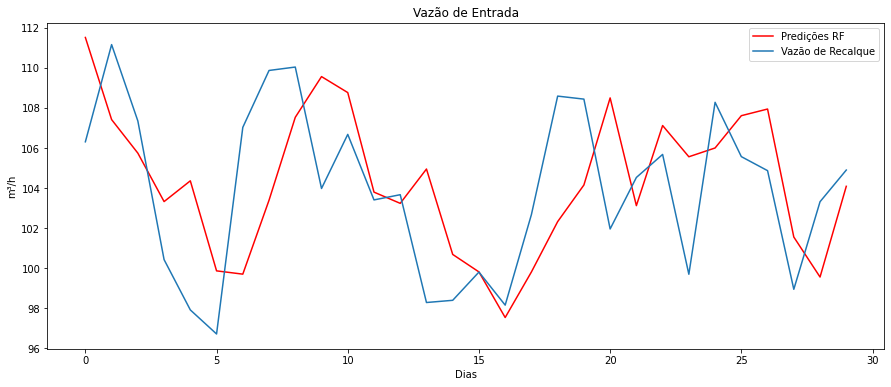

In [71]:
# Prever os dados utilizando os 70% de teste e depois plotando junto com os 30% de treino
pred=model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(pred, color='red')
plt.title('Vazão de Entrada')
plt.plot(y_test)
plt.legend(['Predições RF', 'Vazão de Recalque'], loc="upper right")
plt.ylabel('m³/h')
plt.xlabel('Dias')
plt.show()

In [69]:
#Calculando Erros
rmse_rf = sqrt(mean_squared_error(pred,y_test))
mse_rf = (mean_squared_error(pred,y_test))
mape_rf = (mean_absolute_percentage_error(pred,y_test))

print('RMSE:',rmse_rf)
print('MSE:',mse_rf)
print('MAPE:',mape_rf)

RMSE: 3.994334713399302
MSE: 15.954709802666686
MAPE: 0.03207536029162352
